# Question 3

In [169]:
import wandb


In [170]:
import math

import torch
import torch.nn as nn
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from skimage import io,transform
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop

%matplotlib inline
import matplotlib.pyplot as plt

In [171]:
df = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [173]:
def show_face(image, camera_position):
    """Show image with landmarks"""
    plt.title(camera_position)
    plt.imshow(image,cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated


In [174]:
def encode_dataframe(df):
    le = LabelEncoder()
    df[1] = df[1].astype(str) + df[2].astype(str)+ df[3].astype(str)
    df[1]  = le.fit_transform(df[1])
    return df

In [175]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(160,160))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 1])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position

In [176]:
batch_size=25

In [177]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                           image_dir='deeplearning/train')

In [178]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                            image_dir='deeplearning/validate')

In [179]:
len(train_dataset)

1838

In [180]:
train_split, validation_split = random_split(train_dataset,[1800,38])

In [181]:
train_dataloader = DataLoader(train_split, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [182]:
validation_dataloader = DataLoader(validation_split, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [183]:
test_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=0)

In [184]:
def angular_error(input,output):
    error = torch.arcos(torch.dot(input,output))
    return error

In [185]:
# Solution

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 80 x 80 after this maxpool
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.MaxPool2d(kernel_size=2, stride=4), # B x 12 x20 x 20,
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),# B x 48 x 18x 18,
            nn.BatchNorm2d(24),
            nn.ReLU()



        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=24*18*18,out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=64)
        )

    def forward(self, x):
        residual = x
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 10
        return x

model = CNN()
model.to(device)
loss_func = nn.CrossEntropyLoss()

In [186]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

952672


In [187]:
images,labels = next(iter(train_dataloader))

In [188]:
images[0].to(device).type()

'torch.cuda.FloatTensor'

In [189]:
labels.to(device).type()

'torch.cuda.LongTensor'

In [190]:
labels =  labels.type(torch.LongTensor)
output = model(images.to(device).float())
print(output.shape)
loss = loss_func(output.to(device),labels.to(device))
print(loss)

torch.Size([25, 64])
tensor(4.2883, device='cuda:0', grad_fn=<NllLossBackward0>)


In [191]:
num_epochs = 30
learning_rate =0.01

In [192]:
wandb.init(project="int3", entity="samk", config=
{"learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size
})
wandb.watch(model, log="all",log_freq=10,)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_accuracy,▁▆▆▆▁▇▇▇▇▇▇██▇▇█▇▆▇▇▇█████▇▇██
train_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇█▇█▇█▇███████████
epoch,29
test_accuracy,0.97368
train_accuracy,0.99056


[]

In [193]:


# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataset)/batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):

    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        pred_y = torch.argmax(output, 1)
        correct += (pred_y == labels).sum()
        total += float(labels.size(0))
        total_loss += loss*images.shape[0]
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataset)
    training_losses.append(total_loss.item())
    training_accuracies.append(correct/total)
    wandb.log({"epoch" : epoch+1 , "train_accuracy":training_accuracies[-1]})
    print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))

    # One epoch on the test set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output,labels)
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels).sum()
            total += float(labels.size(0))
            total_loss += loss*images.shape[0]
        test_accuracy = correct/total
    total_loss /= len(test_dataset)
    testing_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    testing_accuracies.append(test_accuracy)
    wandb.log({"epoch" : epoch+1 , "test_accuracy":test_accuracy})
    print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,test_accuracy))

Train accuracy over epoch 1: 0.2950
Test accuracy at epoch 1: 0.3341
Train accuracy over epoch 2: 0.6150
Test accuracy at epoch 2: 0.7579
Train accuracy over epoch 3: 0.7178
Test accuracy at epoch 3: 0.4227
Train accuracy over epoch 4: 0.8100
Test accuracy at epoch 4: 0.8281
Train accuracy over epoch 5: 0.8233
Test accuracy at epoch 5: 0.8569
Train accuracy over epoch 6: 0.8494
Test accuracy at epoch 6: 0.8912
Train accuracy over epoch 7: 0.8833
Test accuracy at epoch 7: 0.8923
Train accuracy over epoch 8: 0.9189
Test accuracy at epoch 8: 0.9635
Train accuracy over epoch 9: 0.8883
Test accuracy at epoch 9: 0.9287
Train accuracy over epoch 10: 0.8928
Test accuracy at epoch 10: 0.9075
Train accuracy over epoch 11: 0.9067
Test accuracy at epoch 11: 0.9782
Train accuracy over epoch 12: 0.9411
Test accuracy at epoch 12: 0.9695
Train accuracy over epoch 13: 0.9500
Test accuracy at epoch 13: 0.9848
Train accuracy over epoch 14: 0.9406
Test accuracy at epoch 14: 0.9864
Train accuracy over epoc

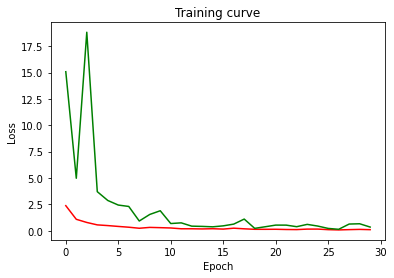

In [194]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(testing_losses)),testing_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

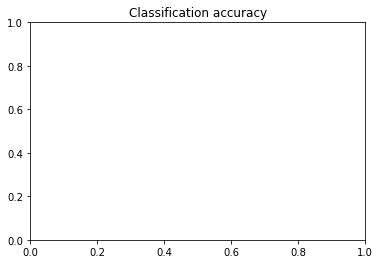

In [195]:
plt.title("Classification accuracy")
plt.plot(range(len(training_accuracies)),training_accuracies,'r')
plt.plot(range(len(testing_accuracies)),testing_accuracies,'g')
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.show()

In [ ]:
test_dataset[0]

In [ ]:
model(test_dataset[0])

In [ ]:
images, labels = next(iter(test_dataloader))

In [ ]:
# Run a test batch through the network
images, labels = next(iter(test_dataloader))
images,labels = images.to(device), labels.to(device)
output = model(images)
pred_y = torch.argmax(output, 1)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    plt.title("{}/{}".format([labels[i].item()],[pred_y[i].item()]))
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
plt.show()